# TELL Runs for IM3's Experiment Group B 

This notebook executes the initial set of runs of the TELL model for IM3's Experiment Group B.

In [1]:
# Start by importing the TELL package and information about your operating system:
import os 
import tell

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tell.package_data import get_ba_abbreviations


## Set the Directory Structure

In [2]:
# Identify the top-level directory and the subdirectory where the data will be stored:
current_dir =  '/Users/burl878/Documents/Research/IMMM/Data/TELL/Production_Runs'
tell_data_dir = os.path.join(current_dir, r'tell_data')

# If the "tell_data_dir" subdirectory doesn't exist then create it:
if not os.path.exists(tell_data_dir):
   os.makedirs(tell_data_dir)


## Run the MLP Models

In [ ]:
# Generate a list of BA abbreviations to process:
ba_abbrev_list = tell.get_balancing_authority_to_model_dict().keys()

scenario_to_process = 'rcp85hotter_ssp5'

# Run the MLP prediction step for the list of BAs using parallel processing streams:
for year_to_process in range(2020,2100,1):
    pdf = tell.predict_batch(target_region_list = ba_abbrev_list,
                             year = year_to_process,
                             data_dir = os.path.join(tell_data_dir, r'wrf_to_tell_data', scenario_to_process),
                             datetime_field_name = 'Time_UTC',
                             save_prediction = True,
                             prediction_output_directory = os.path.join(tell_data_dir, r'outputs', r'mlp_output', scenario_to_process),
                             n_jobs = -1)


## Run the Forward Execution

In [ ]:
# Run the TELL model forward in time for a given year in five year increments out to 2100:
for year in range(2090,2100,1):
    summary_df, ba_time_series_df, state_time_series_df = tell.execute_forward(year_to_process = str(year),
                                                                               gcam_target_year = '2095', 
                                                                               scenario_to_process = 'rcp85hotter_ssp5',
                                                                               data_output_dir = '/Users/burl878/Documents/Research/IMMM/Data/TELL/Production_Runs/tell_data/outputs/tell_output',
                                                                               gcam_usa_input_dir = '/Users/burl878/Documents/Research/IMMM/Data/TELL/Production_Runs/tell_data/gcamusa_data',
                                                                               map_input_dir = '/Users/burl878/Documents/Research/IMMM/Data/TELL/Production_Runs/tell_data/ba_service_territory_data',
                                                                               mlp_input_dir = '/Users/burl878/Documents/Research/IMMM/Data/TELL/Production_Runs/tell_data/outputs/mlp_output',
                                                                               pop_input_dir = '/Users/burl878/Documents/Research/IMMM/Data/TELL/Production_Runs/tell_data/population_data',
                                                                               save_county_data = False)


## Visualize the Output

In [3]:
# Define a function to plot the interannual variability for a given BA or state:
def plot_load_duration_curve_variability(plot_ba, entity_to_plot: str, top_x_hours: int, scenario_to_plot: str, data_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    """Plot the interannual variability of the load duration curve for a given BA or state

    :param plot_ba:             Set to True if you want to plot the output for BAs
    :type plot_ba:              bool

    :param entity_to_plot:      BA code or state abbreviation for entity you want to plot
    :type entity_to_plot:       str

    :param top_x_hours:         Number of peak hours to be included in the load duration curve plot
    :type top_x_hours:          int

    :param scenario_to_plot:    Scenario you want to plot
    :type scenario_to_plot:     str

    :param data_input_dir:      Top-level data directory for TELL
    :type data_input_dir:       str

    :param image_output_dir:    Directory to store the images
    :type image_output_dir:     str

    :param image_resolution:    Resolution at which you want to save the images in DPI
    :type image_resolution:     int

    :param save_images:         Set to True if you want to save the images after they're generated
    :type save_images:          bool

    """

    # Set the data input directory:
    tell_data_input_dir = os.path.join(data_input_dir, r'outputs', r'tell_output', scenario_to_plot)

    # Set the image output directory:
    image_dir = os.path.join(image_output_dir, scenario_to_plot)

    # If the output directory doesn't exist then create it:
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
    
    # Make the plot:
    plt.figure(figsize=(25, 10))
        
    for base_year in range(2025,2105,10):
        if plot_ba:
           for year_delta in range(-5,5,1):
               # Read in the 'TELL_Balancing_Authority_Hourly_Load_Data_' .csv file and parse the time variable:
               hourly_load_df = pd.read_csv((tell_data_input_dir + '/' + str(base_year) + '/' + 'TELL_Balancing_Authority_Hourly_Load_Data_' + str(base_year + year_delta) + '_Scaled_' + str(base_year) + '.csv'), parse_dates=["Time_UTC"])

               # Subset the dataframe to only the BA you want to plot:
               subset_df = hourly_load_df.loc[hourly_load_df['BA_Code'] == entity_to_plot]

               # Sort the hourly load values from largest to smallest and compute the hourly duration for each value:
               load_df_sorted_df = subset_df.sort_values(by=['Scaled_TELL_BA_Load_MWh'], ascending=False)
               load_df_sorted_df['Year'] = str(base_year + year_delta)
               load_df_sorted_df['Interval'] = 1
               load_df_sorted_df['Duration'] = load_df_sorted_df['Interval'].cumsum()
                  
               # Rename the load variable:
               load_df_sorted_df.rename(columns={'Scaled_TELL_BA_Load_MWh': 'Load_MWh'}, inplace=True)
            
               # Subset and reorder the columns:
               output_df = load_df_sorted_df[['Year', 'Duration', 'Load_MWh']]
        
               # Aggregate the output into a new dataframe:
               if year_delta == -5:
                  aggregate_output_df = output_df
               else:
                  aggregate_output_df = pd.concat([aggregate_output_df, output_df])

           aggregate_output_df = aggregate_output_df.loc[aggregate_output_df['Duration'] <= top_x_hours]
        
           if base_year == 2025:
              index = 1
           else:
              index = int(((base_year - 2025)/10) + 1)
        
           plt.subplot(2,4,index)
           for year_delta in range(-5,6,1):
               plt.plot(aggregate_output_df['Duration'].loc[aggregate_output_df['Year'] == str(base_year + year_delta)], 
                        aggregate_output_df['Load_MWh'].loc[aggregate_output_df['Year'] == str(base_year + year_delta)], 
                        color='gray', linestyle='-', label=('Load: ' + str(base_year + year_delta)), linewidth=1)
           plt.plot(aggregate_output_df['Duration'].loc[aggregate_output_df['Year'] == str(base_year)], aggregate_output_df['Load_MWh'].loc[aggregate_output_df['Year'] == str(base_year)],
                    color='black', linestyle='-', label='Base Year Load', linewidth=4)
           plt.xlim((0,top_x_hours))
           plt.xlabel("Duration [h]")
           plt.ylabel("Hourly Load [MWh]")
           plt.title((entity_to_plot + ' LDCs in ' + str(base_year) + ': ' + scenario_to_plot))
        
        if plot_ba == False:
           for year_delta in range(-5,5,1):
               # Read in the 'TELL_State_Summary_Data' .csv file and parse the time variable:
               hourly_load_df = pd.read_csv((tell_data_input_dir + '/' + str(base_year) + '/' + 'TELL_State_Hourly_Load_Data_' + str(base_year + year_delta) + '_Scaled_' + str(base_year) + '.csv'), parse_dates=["Time_UTC"])

               # Subset the dataframe to only the state you want to plot:
               subset_df = hourly_load_df.loc[hourly_load_df['State_Name'] == entity_to_plot]

               # Sort the hourly load values from largest to smallest and compute the hourly duration for each value:
               load_df_sorted_df = subset_df.sort_values(by=['Scaled_TELL_State_Load_MWh'], ascending=False)
               load_df_sorted_df['Year'] = str(base_year + year_delta)
               load_df_sorted_df['Interval'] = 1
               load_df_sorted_df['Duration'] = load_df_sorted_df['Interval'].cumsum()
                  
               # Rename the load variable:
               load_df_sorted_df.rename(columns={'Scaled_TELL_State_Load_MWh': 'Load_MWh'}, inplace=True)
            
               # Subset and reorder the columns:
               output_df = load_df_sorted_df[['Year', 'Duration', 'Load_MWh']]
        
               # Aggregate the output into a new dataframe:
               if year_delta == -5:
                  aggregate_output_df = output_df
               else:
                  aggregate_output_df = pd.concat([aggregate_output_df, output_df])

           aggregate_output_df = aggregate_output_df.loc[aggregate_output_df['Duration'] <= top_x_hours]
        
           if base_year == 2025:
              index = 1
           else:
              index = int(((base_year - 2025)/10) + 1)
        
           plt.subplot(2,4,index)
           for year_delta in range(-5,6,1):
               plt.plot(aggregate_output_df['Duration'].loc[aggregate_output_df['Year'] == str(base_year + year_delta)], 
                        aggregate_output_df['Load_MWh'].loc[aggregate_output_df['Year'] == str(base_year + year_delta)], 
                        color='gray', linestyle='-', label=('Load: ' + str(base_year + year_delta)), linewidth=1)
           plt.plot(aggregate_output_df['Duration'].loc[aggregate_output_df['Year'] == str(base_year)], aggregate_output_df['Load_MWh'].loc[aggregate_output_df['Year'] == str(base_year)],
                    color='black', linestyle='-', label='Base Year Load', linewidth=4)
           plt.xlim((0,top_x_hours))
           plt.xlabel("Duration [h]")
           plt.ylabel("Hourly Load [MWh]")
           plt.title((entity_to_plot + ' LDCs in ' + str(base_year) + ': ' + scenario_to_plot))

    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       if plot_ba:
          ba_name = entity_to_plot
          filename = ('TELL_BA_LDC_Variability_' + ba_name + '_' + scenario_to_plot + '.png')
          plt.savefig(os.path.join(image_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')   
       if plot_ba == False:
          state_name = entity_to_plot
          state_name = state_name.replace(" ", "_")
          filename = ('TELL_State_LDC_Variability_' + state_name + '_' + scenario_to_plot + '.png')
          plt.savefig(os.path.join(image_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')


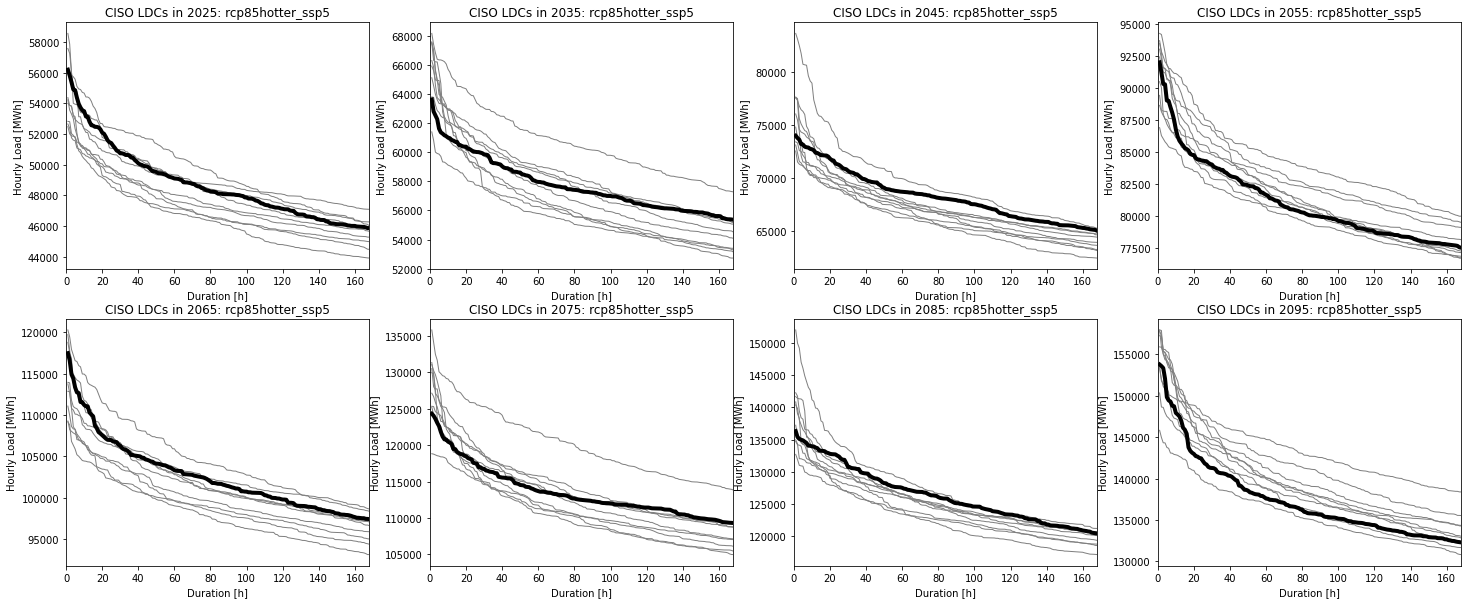

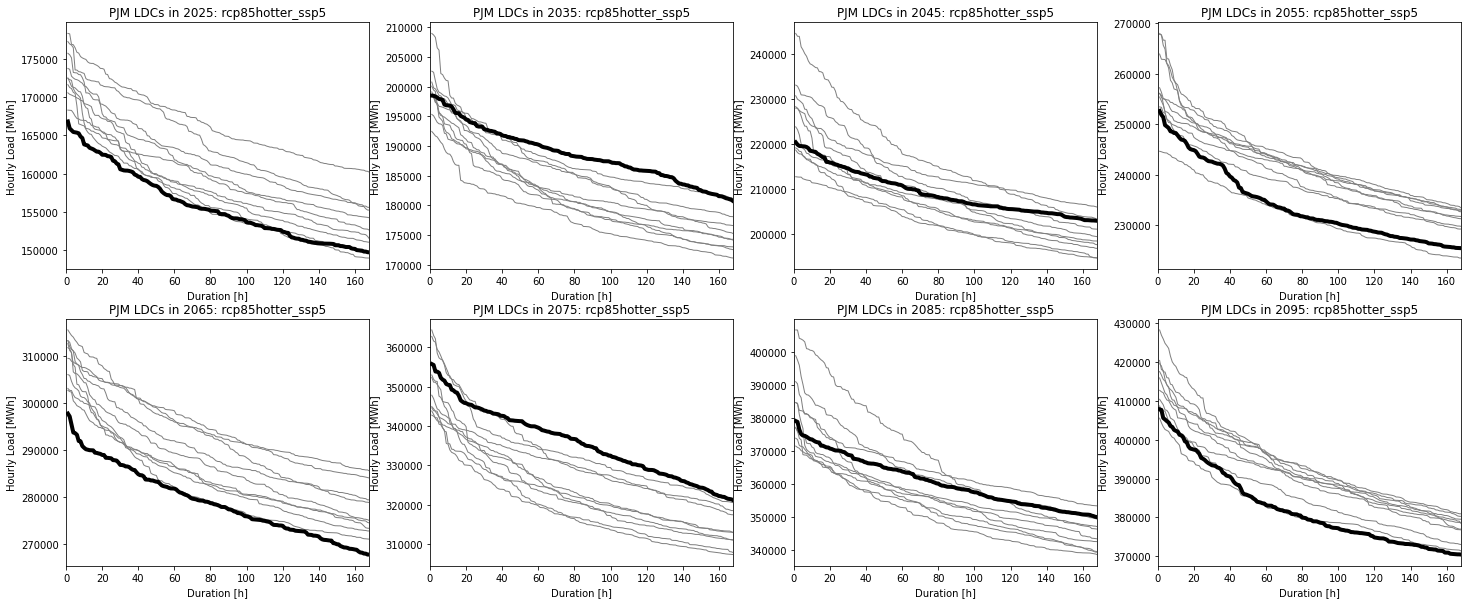

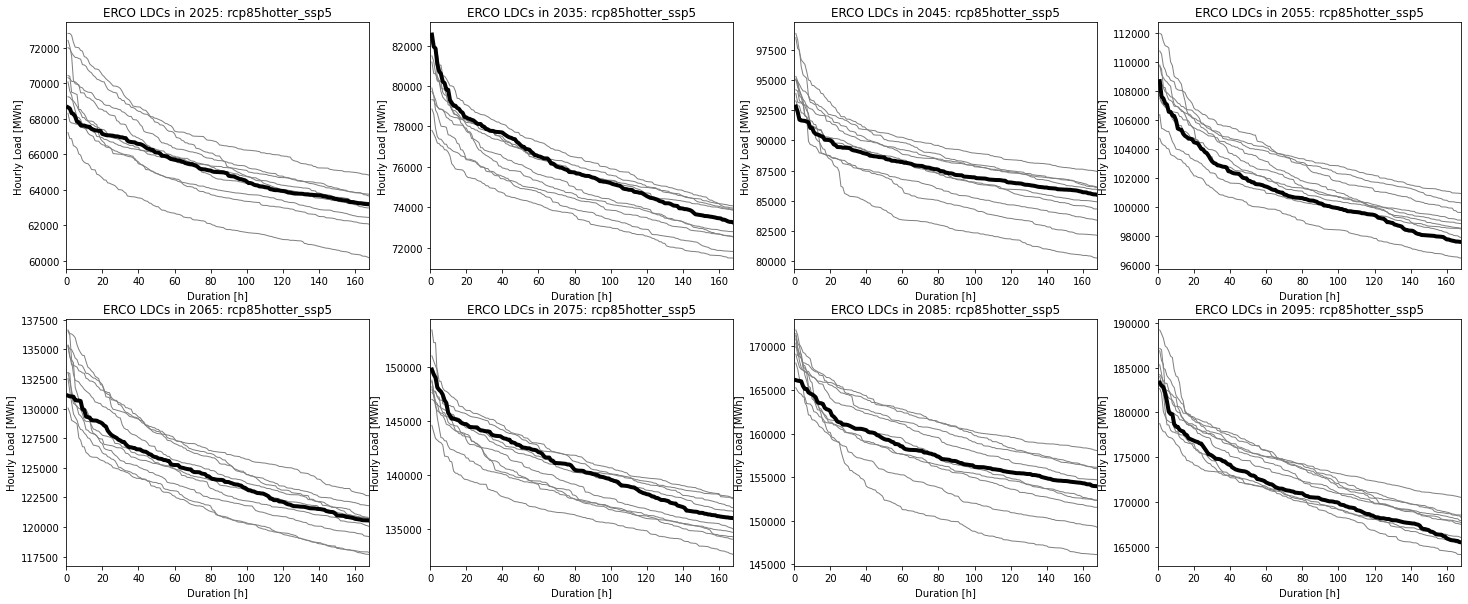

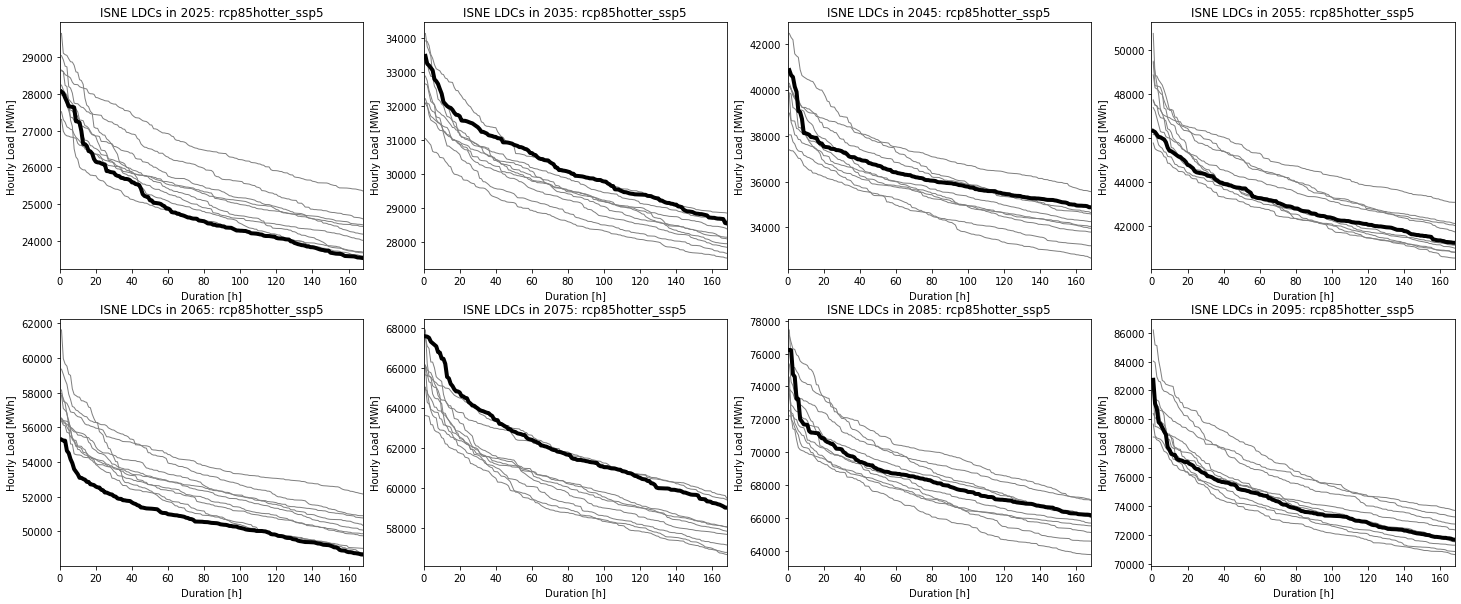

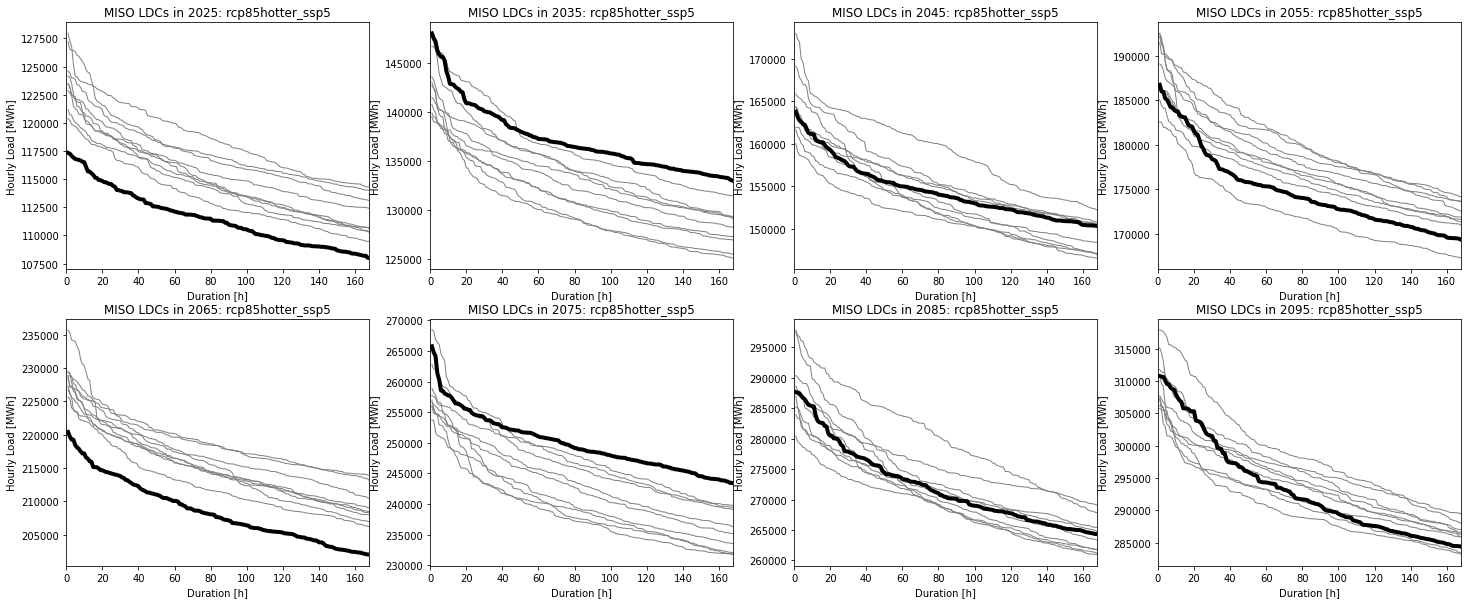

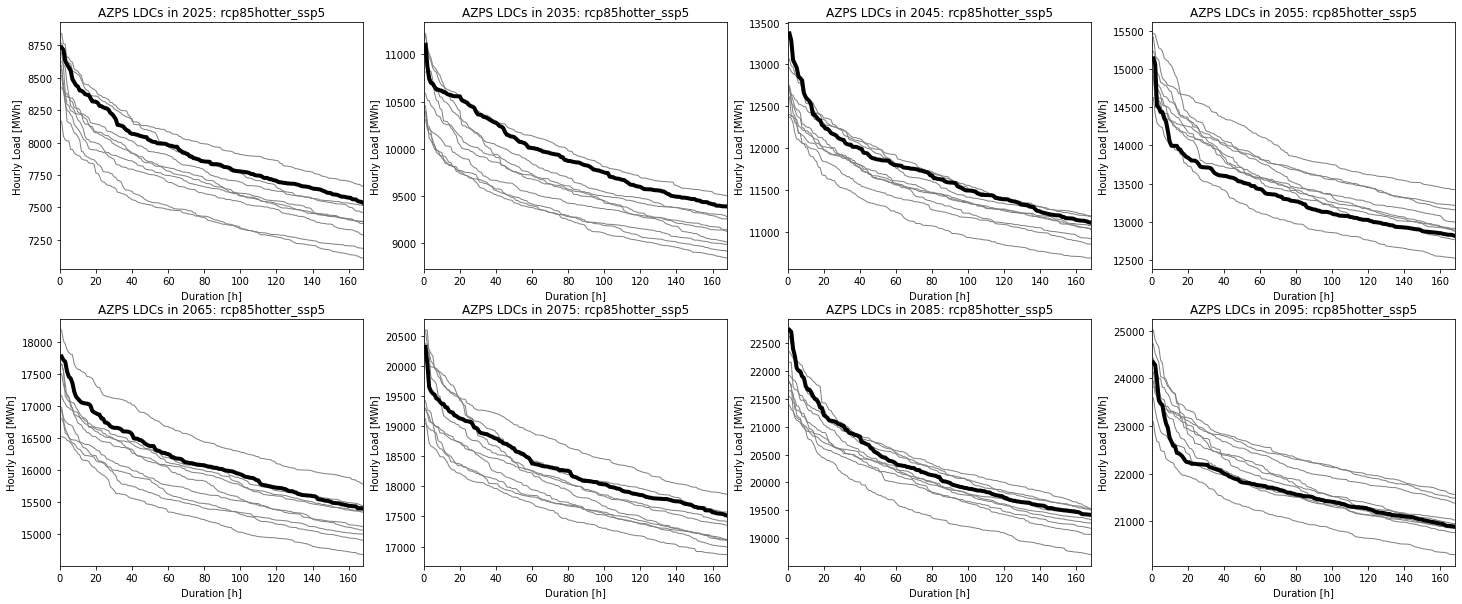

In [5]:
# Get a list of BA abbreviations to process:
#ba_names = get_ba_abbreviations()
ba_names = ['CISO', 'PJM', 'ERCO', 'ISNE', 'MISO', 'AZPS']
ba_names = ['CISO']

# Loop over the list of BAs and make the LDC plot for each BA:
for i in ba_names:
    plot_load_duration_curve_variability(plot_ba = True,
                                         entity_to_plot = i, 
                                         top_x_hours = 168, 
                                         scenario_to_plot = 'rcp85hotter_ssp5', 
                                         data_input_dir = tell_data_dir,
                                         image_output_dir = '/Users/burl878/Documents/code_repos/tell/tell/production_visualizations', 
                                         image_resolution = 50, 
                                         save_images = True)
    plt.close()
